In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def createDataframe(stockName,bb_intervals,bb_std):
    df = pd.read_csv("../data/stocks/yf/"+stockName+".csv",index_col=0)
    for sma_period in bb_intervals:
        field_name = "SMA_%d" % (sma_period)
        df[field_name] = df['Close'].rolling(sma_period).mean()
        for std_period in bb_std:
            field_name_up = "BB_UP_%d_%s" % (sma_period,std_period)
            field_name_down = "BB_DOWN_%d_%s" % (sma_period,std_period)
            df[field_name_up] = df['Close'].rolling(sma_period).mean() + std_period*df['Close'].rolling(sma_period).std()
            df[field_name_down] = df['Close'].rolling(sma_period).mean() - std_period*df['Close'].rolling(sma_period).std()
        Donchian_Channel_up = "DC_Up_%d" % (sma_period)
        Donchian_Channel_down = "DC_Down_%d" % (sma_period)
        df[Donchian_Channel_up] = df['High'].rolling(sma_period).max()
        df[Donchian_Channel_down] = df['Low'].rolling(sma_period).min()
    return df

In [18]:
def createLags(df,shift_lag,frwd_lag):
    newdata = df['Close'].to_frame()
    for lag in shift_lag:
        shift = lag
        shifted = df.shift(shift)
        shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
        newdata = pd.concat((newdata,shifted),axis=1)
    
    newdata['target'] = newdata['Close'].shift(-frwd_lag)
    newdata = newdata.drop('Close',axis=1)
    newdata = newdata.dropna()
    return newdata

In [19]:
def runLinearRegression(df,size,features, draw_chart):
    X = df.drop("target",axis=1)
    Y = df['target']

    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(1-size), random_state=42)
    train_size = int(X.shape[0]*size)

    X_train = X[0:train_size]
    y_train = Y[0:train_size]

    X_test = X[train_size:]
    y_test = Y[train_size:]
    correlations = np.abs(X_train.corrwith(y_train))
    features =  list(correlations.sort_values(ascending=False)[0:features].index)
    X_train = X_train[features]
    X_test = X_test[features]
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    err= mean_absolute_error(y_test,y_pred)
    if (draw_chart):
        plt.scatter(y_test,y_pred)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Linear regression")
        plt.show()
    return err

In [23]:
def runLinearBaggingRegression(df,size,features, draw_chart):
    X = df.drop("target",axis=1)
    Y = df['target']

    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(1-size), random_state=42)
    train_size = int(X.shape[0]*size)

    X_train = X[0:train_size]
    y_train = Y[0:train_size]

    X_test = X[train_size:]
    y_test = Y[train_size:]
    correlations = np.abs(X_train.corrwith(y_train))
    features =  list(correlations.sort_values(ascending=False)[0:features].index)
    X_train = X_train[features]
    X_test = X_test[features]
    lr_bag = RandomizedSearchCV(BaggingRegressor(LinearRegression()),param_distributions =  {
                                'n_estimators':np.arange(10,200,5),
                                'max_features':np.arange(1,5,1)
                            },
                            cv=5, n_iter = 20,
                            iid=False,random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

    lr_bag.fit(X_train,y_train)
    y_pred = lr_bag.predict(X_test)
    err= mean_absolute_error(y_test,y_pred)
    if (draw_chart):
        plt.scatter(y_test,y_pred)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Linear regression Bagging")
        plt.show()
    return err

In [24]:
def runRandomForest(df,size,features, draw_chart):
    X = df.drop("target",axis=1)
    Y = df['target']

    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(1-size), random_state=42)
    train_size = int(X.shape[0]*size)

    X_train = X[0:train_size]
    y_train = Y[0:train_size]

    X_test = X[train_size:]
    y_test = Y[train_size:]
    correlations = np.abs(X_train.corrwith(y_train))
    features =  list(correlations.sort_values(ascending=False)[0:features].index)
    X_train = X_train[features]
    X_test = X_test[features]
    rf = RandomizedSearchCV(RandomForestRegressor(),param_distributions =  {
                                'n_estimators':np.arange(10,200,5),
                                'max_features':np.arange(1,5,1)
                            },
                            cv=5, n_iter = 20,
                            iid=False,random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    err=mean_absolute_error(y_test,y_pred)
    if (draw_chart):
        plt.scatter(y_test,y_pred)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Random FOrest")
        plt.show()
    return err

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


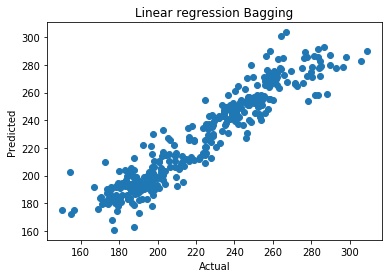

9.246286952676085

In [27]:
stockname ='ITC.BO_Weekly'
bb_intervals = [5,8,10,12,20,50]
bb_std = [1,2]
shift_lag = [1,2,3,4,5,6,7,8]
frwd_lag = 1
test_sample_size = 0.7
features_count = 5
draw_chart = True

df = createDataframe(stockname,bb_intervals,bb_std)
df1 = createLags(df,shift_lag,frwd_lag)
#runLinearRegression(df1,test_sample_size,features_count,draw_chart)
#runRandomForest(df1,test_sample_size,features_count,draw_chart)
runLinearBaggingRegression(df1,test_sample_size,features_count,draw_chart)